Modeling and Evaluation Notebook:

Pipeline Setup
Train/Test Split or 5-fold cross-validation
Models:
- Logistic Regression baseline 
- Additional models: Random Forest, Gradient Boosting (XGBoost), Neural Network, SVM with RBF Kernel
- Super additional models: DecisionTree ("low end"), Genetic Algorithm ("high end")
Evaluation (accuracy, AUC, Precision, Recall, F1)
Debiasing method + fairness metrics
Reflection and interpretation

Pipeline Setup:

In [6]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, roc_curve

# 2. Load Data
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# 3. Define scoring metrics
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
    'accuracy': make_scorer(accuracy_score)
}

# 4. Create pipelines for each model
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}



Pipeline Setup: 5-fold crossvalidation
Use StratifiedKfold to ensure that each fold in the cross-validation process has approximately the same proportion of target classes (recidivist vs. non-recidivist) as the full dataset. 
The is_recid target is imbalanced (around 30–35% positive class).

c:\Users\wastl\modelengineering\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:07:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\wastl\modelengineering\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:07:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\wastl\modelengineering\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:07:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\User

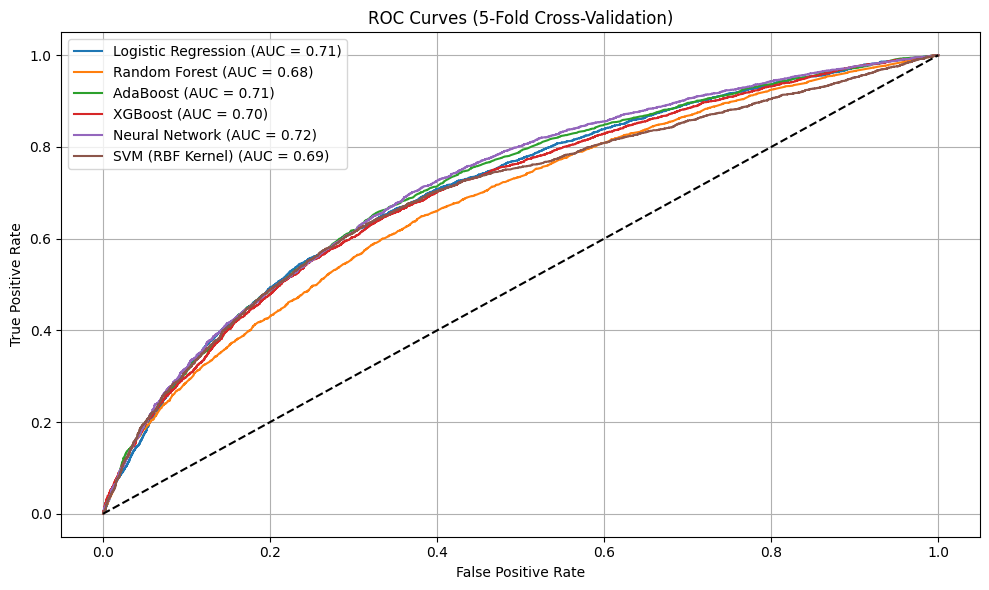

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Neural Network,0.698,0.616,0.386,0.475,0.717
1,AdaBoost,0.692,0.596,0.402,0.480,0.712
2,Logistic Regression,0.689,0.645,0.271,0.381,0.707
3,XGBoost,0.691,0.589,0.423,0.492,0.702
4,SVM (RBF Kernel),0.690,0.634,0.296,0.404,0.693
5,Random Forest,0.662,0.526,0.470,0.496,0.678


In [18]:
# Re-import required packages after kernel reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# Load the dataset
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# Initialize 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Use StratifiedKfold for imbalanced classes

# Define models with pipelines
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(n_estimators=100, random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

# Evaluate each model
results = []
plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba")[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    acc = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)

    fpr, tpr, _ = roc_curve(y, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3)
    })

# Plot formatting
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (5-Fold Cross-Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/model_comparison_roc_curves_with_adaboost.png")
plt.show()

# Show results
results_df = pd.DataFrame(results)
results_df.sort_values("AUC", ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df.to_csv("../reports/model_performance_comparison_5-foldcv.csv", index=False)
results_df



Pipeline Setup: alternatively 80/20 Train/Test Split

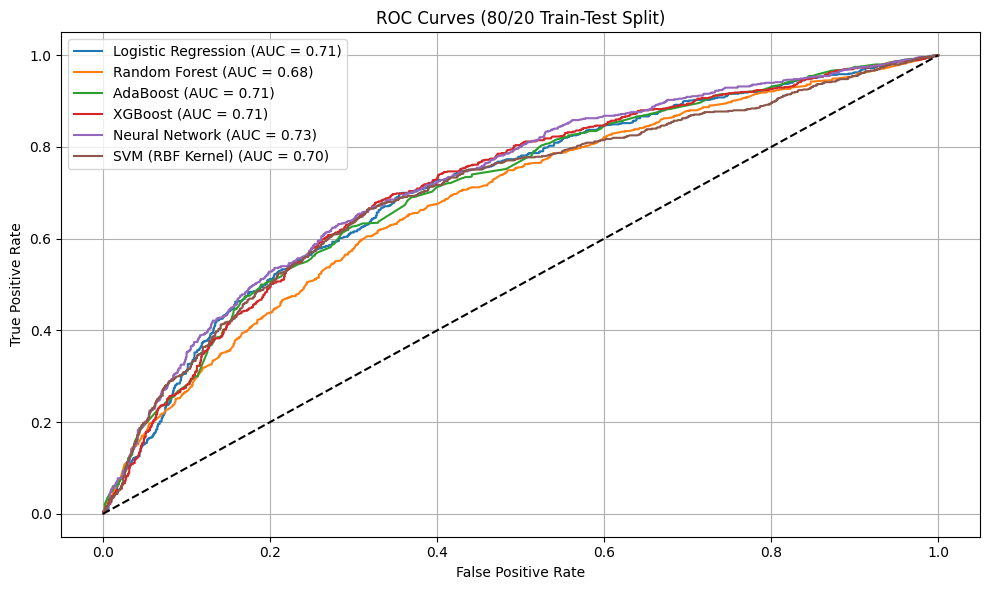

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Neural Network,0.706,0.635,0.397,0.489,0.725
1,XGBoost,0.696,0.600,0.423,0.496,0.714
2,Logistic Regression,0.690,0.638,0.284,0.393,0.711
3,AdaBoost,0.695,0.604,0.401,0.482,0.709
4,SVM (RBF Kernel),0.695,0.651,0.299,0.410,0.702
5,Random Forest,0.665,0.529,0.493,0.510,0.683


In [22]:
# Re-import required packages after kernel reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# Load the dataset
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# Perform 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define models with pipelines
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(n_estimators=100, random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

# Evaluate each model
results = []
plt.figure(figsize=(10, 6))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3)
    })

# Plot formatting
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (80/20 Train-Test Split)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/model_comparison_roc_curves_80-20split.png")
plt.show()

# Show results
results_df = pd.DataFrame(results)
results_df.sort_values("AUC", ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df.to_csv("../reports/model_performance_comparison_80-20ttsplit.csv", index=False)
results_df



Evaluation (Precision, Recall, F1)
Debiasing method + fairness metrics
Reflection and interpretation